In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import imblearn
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam

In [ ]:
# loading the dataset to a Pandas DataFrame
credit_card_data = pd.read_csv('sample_data/creditcard.csv')
credit_card_data['Class'].value_counts()

,count
Class,
0,284315
1,492


**`Implement the Balanced Logistic Regression Model as a baseline method. `**

In [ ]:
# separating the data for analysis
legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]
legit_sample = legit.sample(n=492)

new_dataset = pd.concat([legit_sample, fraud], axis=0)

X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

model = LogisticRegression(class_weight='balanced')

# training the Logistic Regression Model with Training Data
model.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [ ]:
# accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
training_data_f1 = f1_score(Y_train, X_train_prediction)
training_data_recall = recall_score(Y_train, X_train_prediction)
training_data_precision = precision_score(Y_train, X_train_prediction)

print('Accuracy on Training data : ', training_data_accuracy)
print('Precision Score on Training Data: ', training_data_precision)
print('Recall Score on Training Data: ', training_data_recall)
print('F1 Score on Training Data: ', training_data_f1)

Accuracy on Training data :  0.940279542566709
Precision Score on Training Data:  0.9626666666666667
Recall Score on Training Data:  0.916243654822335
F1 Score on Training Data:  0.9388816644993498


In [ ]:
# accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)
test_data_recall = recall_score(Y_test, X_test_prediction)
test_data_precision = precision_score(Y_test, X_test_prediction)

print('Accuracy score on Test Data : ', test_data_accuracy)
print('F1 Score on Test Data: ', test_data_f1)
print('Precision Score on Training Data: ', test_data_precision)
print('Recall Score on Training Data: ', test_data_recall)


Accuracy score on Test Data :  0.9441624365482234
F1 Score on Test Data:  0.9417989417989417
Precision Score on Training Data:  0.978021978021978
Recall Score on Training Data:  0.9081632653061225


**Implement the neural network as an advanced method (same as midterm report)**

---



In [ ]:
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight

# Prepare the data
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

# Split data into training, validation, and test sets (70-20-10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=42)  # Additional split for validation

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter options:
epochs_options = [10, 20]
batch_size_options = [32, 64]
dropout_rate_options = [0.3, 0.4]

# Initialize variables to track the best performance
best_f1 = 0
best_params = {}

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Store results of each hyperparameter experiment
experiment_results = []


# Calculate weights based on class distribution in y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create class_weights_dict using actual class labels as keys
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Track the best performance and the best hyperparameters to generate that performance
for epochs in epochs_options:
  for batch_size in batch_size_options:
    for dropout_rate in dropout_rate_options:
      # Initialize the Neural Network model with current hyperparameters
      model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),  # Increased hidden layer size
        Dropout(dropout_rate),                                             # Dropout layer to reduce overfitting
        Dense(64, activation='relu'),                                      # Another hidden layer
        Dropout(dropout_rate),                                             # Another dropout layer
        Dense(1, activation='sigmoid')                                     # Output layer for binary classification
      ])

      # Compile the model
      model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

      # Train the model on the training set, evaluate on the validation set
      model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val), class_weight=class_weights_dict, verbose = 0)

      # Generate predictions on the validation set
      y_val_pred = (model.predict(X_val_scaled) > 0.3).astype("int32")

      # Calculate F1-score for the validation set
      f1 = f1_score(y_val, y_val_pred)

      # Store the results of this experiment
      experiment_results.append({
        'epochs': epochs,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'f1_score': f1
      })

      # Update best parameters if current model performs better
      if f1 > best_f1:
        best_f1 = f1
        best_params = {
                       'epochs':epochs,
                       'batch_size':batch_size,
                       'dropout_rate':dropout_rate
                       }

print("Best hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

# Train and compile final model using best hyperparameters
best_model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(64, activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit(X_train_scaled, y_train,
               epochs=best_params['epochs'],
               batch_size=best_params['batch_size'],
               class_weight=class_weights_dict,
               verbose=0)

# Evaluate final model on test set
y_pred_nn = (best_model.predict(X_test_scaled) > 0.5).astype("int32")

# Evaluate the performance
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
accuracy = accuracy_score(y_test, y_pred_nn)

# Display evaluation metrics
print(f'Neural Network Model - Accuracy: {accuracy:.4f}, Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, F1-Score: {f1_nn:.4f}')

# Display experiment results
print("Experiment results:", experiment_results)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Best hyperparameters: {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.4}
Best Validation F1-Score: 0.39918533604887985


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network Model - Accuracy: 0.9873, Precision: 0.1010, Recall: 0.8696, F1-Score: 0.1810
Experiment results: [{'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.3, 'f1_score': 0.22916666666666666}, {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.4, 'f1_score': 0.39918533604887985}, {'epochs': 10, 'batch_size': 64, 'dropout_rate': 0.3, 'f1_score': 0.08838821490467938}, {'epochs': 10, 'batch_size': 64, 'dropout_rate': 0.4, 'f1_score': 0.14419610670511895}, {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.3, 'f1_score': 0.07636502481863307}, {'epochs': 20, 'batch_size': 32, 'dropout_rate': 0.4, 'f1_score': 0.2047082906857728}, {'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.3, 'f1_score': 0.1212856276531231}, {'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.4, 'f1_score': 0.2663115845539281}]


**Implement New Model #1 (Newly Created Since Midterm Report): SVM**




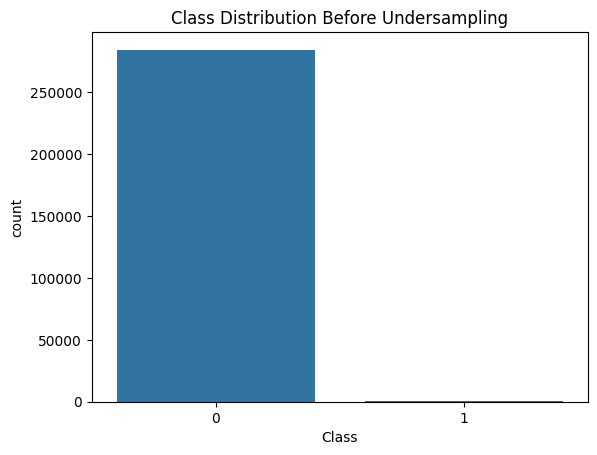

In [ ]:
credit_card_data.head()
sns.countplot(x="Class", data=credit_card_data)
plt.title("Class Distribution Before Undersampling")
plt.show()


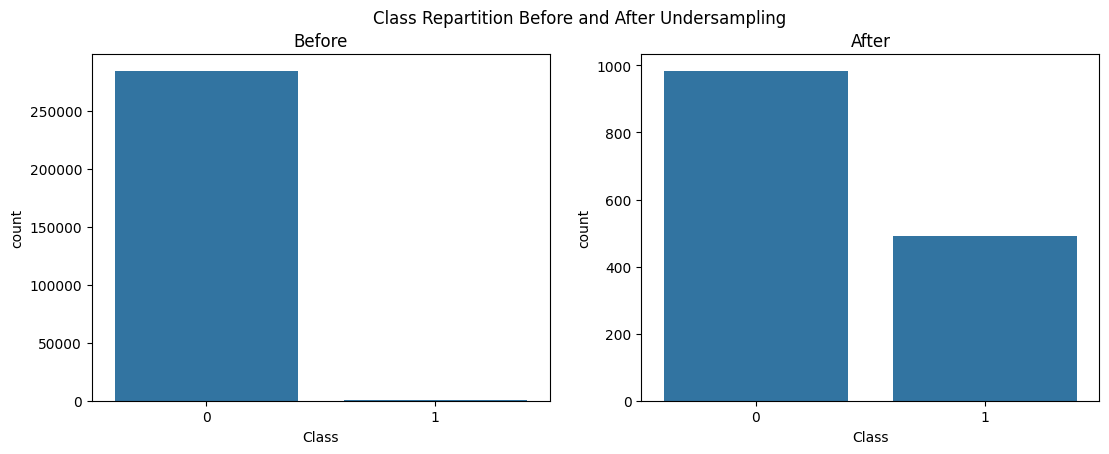

In [ ]:
credit_card_data = credit_card_data.dropna(subset=['Class'])
# Define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)

# Separate features and target variable
cols = credit_card_data.columns.tolist()
cols = [c for c in cols if c != "Class"]
target = "Class"

X = credit_card_data[cols]
Y = credit_card_data[target]

# Apply undersampling
X_under, Y_under = undersample.fit_resample(X, Y)

# Visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13, 4.5))
sns.countplot(x="Class", data=credit_card_data, ax=axs[0])
sns.countplot(x="Class", data=pd.DataFrame(Y_under, columns=["Class"]), ax=axs[1])

fig.suptitle("Class Repartition Before and After Undersampling")
axs[0].set_title("Before")
axs[1].set_title("After")
plt.show()


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with balanced class weights
model = SVC(probability=True, class_weight="balanced", random_state=2)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = model.predict(X_test_scaled)

# Probability scores for AUC-ROC
y_proba_svm = model.predict_proba(X_test_scaled)[:, 1]

# Performance metrics
print("Accuracy SVM:", metrics.accuracy_score(y_test, y_pred_svm))
print("Precision SVM:", metrics.precision_score(y_test, y_pred_svm, zero_division=1))
print("Recall SVM:", metrics.recall_score(y_test, y_pred_svm))
print("F1 Score SVM:", metrics.f1_score(y_test, y_pred_svm))

# Classification report for detailed metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, zero_division=1))


Accuracy SVM: 0.9974017766230119
Precision SVM: 0.34782608695652173
Recall SVM: 0.6956521739130435
F1 Score SVM: 0.463768115942029

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.35      0.70      0.46        46

    accuracy                           1.00     28481
   macro avg       0.67      0.85      0.73     28481
weighted avg       1.00      1.00      1.00     28481



**Implement New Model #2 (Newly Created Since Midterm Report) and the Final method: A Random Forest Implementation.**



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare the data
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

Y = Y.dropna()
X = X.loc[Y.index]  # Ensure alignment between X and Y after dropping rows


# Split data into training, validation, and test sets (70-20-10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Define hyperparameters for tuning
n_estimators_options = [500, 1000]  # Number of trees in the forest
max_depth_options = [10, 20]
min_samples_split_options = [2, 5]
min_samples_leaf_options = [2, 4]
criterion_options = ['gini']

# Initialize variables for tracking performance
best_f1 = 0
best_params = {}
experiment_results = []

# Hyperparameter Tuning
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        for min_samples_split in min_samples_split_options:
            for min_samples_leaf in min_samples_leaf_options:
                for criterion in criterion_options:
                    # Build the Random Forest model
                    rf_model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        criterion=criterion,
                        class_weight='balanced',
                        random_state=42
                    )

                    # Train the model
                    rf_model.fit(X_train_scaled, y_train)

                    # Make predictions on the validation data
                    y_val_pred = rf_model.predict(X_val_scaled)

                    # Calculate F1 score
                    f1 = f1_score(y_val, y_val_pred)
                    print(f"Validation F1-Score: {f1} for n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, criterion={criterion}")

                    # Save results
                    experiment_results.append({
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'criterion': criterion,
                        'f1_score': f1
                    })

                    # Track the best model
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'criterion': criterion
                        }

print("Best hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

# Train final model using best hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight='balanced',
    random_state=42
)

best_rf_model.fit(X_train_scaled, y_train)

# Evaluate on test data
y_test_pred = best_rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")


Validation F1-Score: 0.8127853881278538 for n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=2, criterion=gini
Validation F1-Score: 0.8090909090909091 for n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=4, criterion=gini
Validation F1-Score: 0.8127853881278538 for n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion=gini
Validation F1-Score: 0.8090909090909091 for n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=4, criterion=gini
Validation F1-Score: 0.8155339805825242 for n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=2, criterion=gini
Validation F1-Score: 0.8056872037914692 for n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=4, criterion=gini
Validation F1-Score: 0.8155339805825242 for n_estimators=500, max_depth=20, min_samples_split=5, min_samples_leaf=2, criterion=gini
Validation F1-Score: 0.8056872037914692 for n_estimators=500, max_depth=20, 

**Manual Error Analysis for Discussion on Random Forest:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare the data
credit_card_data = pd.read_csv('sample_data/creditcard.csv')
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

# Split data into training, validation, and test sets (70-20-10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Train final model using best hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    criterion='gini',
    class_weight='balanced',
    random_state=42
)

best_rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=500, random_state=42)

In [ ]:
# Ensure y_val is 1-dimensional
y_val = np.array(y_val).ravel()

# Evaluate on dev data
y_val_pred = best_rf_model.predict(X_val_scaled)


# Identify misclassified examples
misclassified_indices = np.where(y_val != y_val_pred)[0]
misclassified_samples = X_val_scaled[misclassified_indices]
misclassified_labels = y_val[misclassified_indices]
predicted_labels = y_val_pred[misclassified_indices]

# Display a random sample of misclassified examples
print("Random sample of misclassified examples:")
for i in range(min(10, len(misclassified_indices))):  # Limit to 10 samples if available
    print(f"\nSample {i}:")
    print(f"Predicted: {predicted_labels[i]}, Actual: {misclassified_labels[i]}")
    print(f"Features: {misclassified_samples[i]}")

Random sample of misclassified examples:

Sample 0:
Predicted: 0, Actual: 1
Features: [-0.63760437  0.55084767  0.58194324 -0.18210085  1.94190989  0.29748711
 -0.23940203  0.032666    0.14844322 -0.88208413 -0.17755598  2.09933841
 -0.27757692 -1.19527114 -1.96978916  0.43660557  1.56091728  1.80320183
  1.22590933 -1.93986223 -0.22273858 -0.0117136  -0.07790024 -0.0902573
 -0.04454083  0.76931624  0.15209341  0.06741182  0.19117142 -0.34928493]

Sample 1:
Predicted: 0, Actual: 1
Features: [ 7.60819103e-01  2.39523983e-01 -7.49639749e-01 -1.16349542e+00
  3.42059198e+00 -1.91942171e-01 -3.83033287e-01  9.14543926e-01
 -2.87880124e-01 -9.54380975e-01  7.94329897e-02 -1.20991700e-03
 -5.52304760e-02  7.40482636e-01 -2.41594026e+00 -5.07995442e-01
  1.90962674e+00  1.38052941e+00  6.69824696e-01 -2.82982192e+00
  1.65424056e+00  4.15027119e-01 -8.90896740e-01 -6.11122148e-01
  4.30200034e-01 -9.51414433e-01 -5.08944560e-01 -2.91356041e-01
  4.37325975e-01  2.50854202e+00]

Sample 2:
Pred